# **Using CountVectorizer**

In [95]:
import re
import string
import itertools

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
df = pd.read_csv("/content/drive/MyDrive/Machine Learning/NLP/News Classification using NLP/datasets/True.csv")

df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,31-Dec-17
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,29-Dec-17
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,31-Dec-17
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,30-Dec-17
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,29-Dec-17


In [17]:
df.shape

(21417, 4)

### Check the null values

In [18]:
df.isna().sum()

title      0
text       0
subject    0
date       0
dtype: int64

### check the info

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [20]:
# Check the number categories in subject column

df.subject.value_counts()

politicsNews    11272
worldnews       10145
Name: subject, dtype: int64

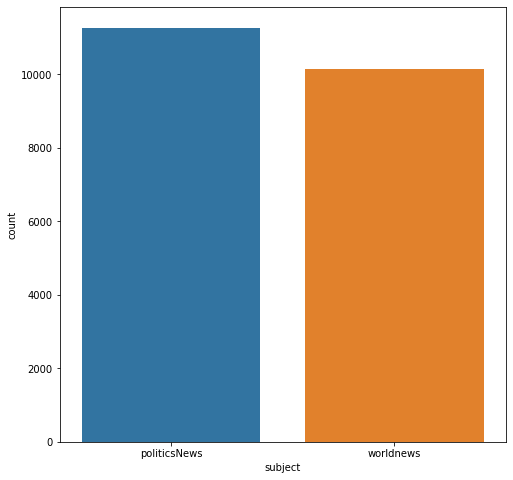

In [21]:
plt.figure(figsize=(8,8))
sns.countplot(x='subject', data=df)
plt.show()

### Check the duplicate vlaue

In [22]:
df.duplicated().sum()

206

In [23]:
df.duplicated().sum().any()

True

In [24]:
df.drop_duplicates(inplace=True)

In [25]:
df.reset_index(drop=True, inplace=True)

In [26]:
df.duplicated().sum()

0

In [27]:
# Pick the necessary column from the entire dataset

df2 = df[['title', 'text', 'subject']].copy()

df2.head()

,title,text,subject
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews


In [31]:
df2.duplicated().sum()

3

In [32]:
df2.drop_duplicates(inplace=True)

In [33]:
df2.reset_index(drop=True, inplace=True)

In [34]:
df2.duplicated().sum()

0

## Split the dataset into independent and dependent variable

In [35]:
X = df2.loc[:, ['title', 'text']]
y = df2.loc[:, 'subject']

In [36]:
X.head()

,title,text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...


In [37]:
y.head()

0    politicsNews
1    politicsNews
2    politicsNews
3    politicsNews
4    politicsNews
Name: subject, dtype: object

In [39]:
# demo test

pd.get_dummies(data=y).head(10)

# demo end

,politicsNews,worldnews
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
5,1,0
6,1,0
7,1,0
8,1,0
9,1,0


In [40]:
y = pd.get_dummies(data=y, drop_first=True)

y.head()

,worldnews
0,0
1,0
2,0
3,0
4,0


In [41]:
# 0 --> politicsNews & 1 --> worldnews

# make 1-D array for our model
y2 = y.iloc[:,0].values

In [42]:
y2

array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)

In [43]:
y2.shape

(21208,)

In [44]:
y2.dtype

dtype('uint8')

## Apply some Text preprocessing

In [45]:
X.loc[0, 'title']

'As U.S. budget fight looms, Republicans flip their fiscal script'

In [46]:
# Demo test

txt = "alamin bhuyan 321 gmail.com"

result = re.sub(pattern=r"[^a-zA-Z]", repl=' ', string=txt)

print(result)

# Demo end

alamin bhuyan     gmail com


In [47]:
def textPreprocess(text):
    text = text.lower()
    text = text.replace("u.s.", "unitedstates")
    patt = re.compile(pattern=r"[^a-zA-Z]")
    # patt = re.compile(pattern=r"\d+")
    text = patt.sub(repl=" ", string=text)
    # text = text.translate(str.maketrans('', '', string.punctuation))
    text = " ".join(text.split()) # for removing white space from text
    return text

In [48]:
# test the function for demo purpose

print(textPreprocess('As U.S. budget fight looms, Republicans flip their fiscal script'))

as unitedstates budget fight looms republicans flip their fiscal script


In [49]:
X['title'] = X['title'].apply(func=textPreprocess)
X['text'] = X['text'].apply(func=textPreprocess)

In [50]:
X.head()

,title,text
0,as unitedstates budget fight looms republicans...,washington reuters the head of a conservative ...
1,unitedstates military to accept transgender re...,washington reuters transgender people will be ...
2,senior unitedstates republican senator let mr ...,washington reuters the special counsel investi...
3,fbi russia probe helped by australian diplomat...,washington reuters trump campaign adviser geor...
4,trump wants postal service to charge much more...,seattle washington reuters president donald tr...


In [51]:
X.shape

(21208, 2)

In [53]:
y2.shape

(21208,)

In [54]:
X['tags'] = X['title'] + X['text']

X.head()

,title,text,tags
0,as unitedstates budget fight looms republicans...,washington reuters the head of a conservative ...,as unitedstates budget fight looms republicans...
1,unitedstates military to accept transgender re...,washington reuters transgender people will be ...,unitedstates military to accept transgender re...
2,senior unitedstates republican senator let mr ...,washington reuters the special counsel investi...,senior unitedstates republican senator let mr ...
3,fbi russia probe helped by australian diplomat...,washington reuters trump campaign adviser geor...,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge much more...,seattle washington reuters president donald tr...,trump wants postal service to charge much more...


In [55]:
# Drop the title and text columns

X.drop(columns=['title', 'text'], inplace=True)

In [56]:
X.head()

,tags
0,as unitedstates budget fight looms republicans...
1,unitedstates military to accept transgender re...
2,senior unitedstates republican senator let mr ...
3,fbi russia probe helped by australian diplomat...
4,trump wants postal service to charge much more...


In [57]:
X.loc[0, 'tags']

'as unitedstates budget fight looms republicans flip their fiscal scriptwashington reuters the head of a conservative republican faction in the unitedstates congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in in keeping with a sharp pivot under way among republicans unitedstates representative mark meadows speaking on cbs face the nation drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek to keep control of congress president donald trump and his republicans want a big budget increase in military spending while democrats also want proportional increases for non defe

In [58]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [59]:
# Demo test for word_tokenize

print(word_tokenize(text=X.loc[0, 'tags']))

# Demo end

['as', 'unitedstates', 'budget', 'fight', 'looms', 'republicans', 'flip', 'their', 'fiscal', 'scriptwashington', 'reuters', 'the', 'head', 'of', 'a', 'conservative', 'republican', 'faction', 'in', 'the', 'unitedstates', 'congress', 'who', 'voted', 'this', 'month', 'for', 'a', 'huge', 'expansion', 'of', 'the', 'national', 'debt', 'to', 'pay', 'for', 'tax', 'cuts', 'called', 'himself', 'a', 'fiscal', 'conservative', 'on', 'sunday', 'and', 'urged', 'budget', 'restraint', 'in', 'in', 'keeping', 'with', 'a', 'sharp', 'pivot', 'under', 'way', 'among', 'republicans', 'unitedstates', 'representative', 'mark', 'meadows', 'speaking', 'on', 'cbs', 'face', 'the', 'nation', 'drew', 'a', 'hard', 'line', 'on', 'federal', 'spending', 'which', 'lawmakers', 'are', 'bracing', 'to', 'do', 'battle', 'over', 'in', 'january', 'when', 'they', 'return', 'from', 'the', 'holidays', 'on', 'wednesday', 'lawmakers', 'will', 'begin', 'trying', 'to', 'pass', 'a', 'federal', 'budget', 'in', 'a', 'fight', 'likely', 'to

## Apply WordNetLemmatizer

In [60]:
lemmatizer = WordNetLemmatizer()

In [61]:
def textLemmatizer(text):
    words = word_tokenize(text=text)
    text = [lemmatizer.lemmatize(word=word) for word in words if word not in stopwords.words('english')]
    text = " ".join(text) # convert the list into text
    return text

In [ ]:
nltk.download('all')

In [63]:
# Demo test for textLemmatizer() function

result = textLemmatizer("""as unitedstates budget fight looms republicans flip their fiscal scriptwashington reuters the head of a conservative republican faction in the unitedstates congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in in keeping with a sharp pivot under way among republicans unitedstates representative mark meadows speaking on cbs face the nation drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek to keep control of congress president donald trump and his republicans want a big budget increase in military spending while democrats also want proportional increases for non defense discretionary spending on programs that support education scientific research infrastructure public health and environmental protection the trump administration has already been willing to say we re going to increase non defense discretionary spending by about percent meadows chairman of the small but influential house freedom caucus said on the program now democrats are saying that s not enough we need to give the government a pay raise of to percent for a fiscal conservative i don t see where the rationale is eventually you run out of other people s money he said meadows was among republicans""")

result

# Demo end

'unitedstates budget fight loom republican flip fiscal scriptwashington reuters head conservative republican faction unitedstates congress voted month huge expansion national debt pay tax cut called fiscal conservative sunday urged budget restraint keeping sharp pivot way among republican unitedstates representative mark meadow speaking cbs face nation drew hard line federal spending lawmaker bracing battle january return holiday wednesday lawmaker begin trying pas federal budget fight likely linked issue immigration policy even november congressional election campaign approach republican seek keep control congress president donald trump republican want big budget increase military spending democrat also want proportional increase non defense discretionary spending program support education scientific research infrastructure public health environmental protection trump administration already willing say going increase non defense discretionary spending percent meadow chairman small inf

In [64]:
X['tags'] = X['tags'].apply(func=textLemmatizer)

X.head()

,tags
0,unitedstates budget fight loom republican flip...
1,unitedstates military accept transgender recru...
2,senior unitedstates republican senator let mr ...
3,fbi russia probe helped australian diplomat ti...
4,trump want postal service charge much amazon s...


# **Apply CounterVectorizer**



In [65]:
# max_features use for reduce number of columns

cv = CountVectorizer(max_features=5000,ngram_range=(1,4))

In [66]:
X = cv.fit_transform(raw_documents=X['tags']).toarray()

In [67]:
cv.get_feature_names_out()

array(['abadi', 'abandon', 'abandoned', ..., 'zone', 'zor', 'zuma'],
      dtype=object)

In [69]:
cv.get_feature_names_out()[:50]

array(['abadi', 'abandon', 'abandoned', 'abbas', 'abc', 'abdullah', 'abe',
       'ability', 'able', 'abortion', 'abroad', 'absence', 'absolutely',
       'abu', 'abuse', 'academic', 'accept', 'accepted', 'accepting',
       'access', 'accident', 'accord', 'according', 'according reuters',
       'account', 'accountability', 'accountable', 'accuracy',
       'accusation', 'accuse', 'accused', 'accuses', 'accusing',
       'achieve', 'achieved', 'achievement', 'acknowledged', 'across',
       'across country', 'act', 'acted', 'acting', 'action', 'active',
       'activist', 'activity', 'actor', 'actually', 'ad', 'adam'],
      dtype=object)

In [70]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 5000,
 'min_df': 1,
 'ngram_range': (1, 4),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [71]:
cv.vocabulary_

{'unitedstates': 4642,
 'budget': 512,
 'fight': 1536,
 'republican': 3500,
 'fiscal': 1569,
 'reuters': 3586,
 'head': 1833,
 'conservative': 829,
 'faction': 1468,
 'congress': 819,
 'voted': 4800,
 'month': 2640,
 'huge': 1939,
 'expansion': 1427,
 'national': 2695,
 'debt': 1013,
 'pay': 2993,
 'tax': 4320,
 'cut': 977,
 'called': 536,
 'sunday': 4250,
 'urged': 4730,
 'keeping': 2212,
 'sharp': 3971,
 'way': 4842,
 'among': 176,
 'representative': 3492,
 'mark': 2486,
 'speaking': 4089,
 'cbs': 603,
 'face': 1461,
 'nation': 2693,
 'drew': 1219,
 'hard': 1819,
 'line': 2375,
 'federal': 1512,
 'spending': 4102,
 'lawmaker': 2298,
 'battle': 382,
 'january': 2149,
 'return': 3583,
 'holiday': 1888,
 'wednesday': 4853,
 'begin': 394,
 'trying': 4576,
 'pas': 2976,
 'likely': 2368,
 'linked': 2377,
 'issue': 2134,
 'immigration': 1980,
 'policy': 3085,
 'even': 1398,
 'november': 2814,
 'congressional': 820,
 'election': 1283,
 'campaign': 544,
 'approach': 233,
 'seek': 3875,
 'keep

In [74]:
print(len(cv.get_feature_names_out()))

5000


# **Split the dataset into train, test**

In [76]:
xtrain, xtest, ytrain, ytest = train_test_split(X, y2, test_size=0.3, random_state=11)

In [77]:
xtrain.shape, ytrain.shape

((14845, 5000), (14845,))

In [78]:
xtest.shape, ytest.shape

((6363, 5000), (6363,))

In [79]:
# make a data frame to see how does look like the metric

count_df = pd.DataFrame(xtrain, columns=cv.get_feature_names_out())

count_df.head()

,abadi,abandon,abandoned,abbas,abc,abdullah,abe,ability,able,abortion,...,zanu pf,zarrab,zealand,zero,zika,zimbabwe,zinke,zone,zor,zuma
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0


In [80]:
ytrain

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

# **Apply MultinomialNB algorithm**

In [81]:
model = MultinomialNB().fit(X=xtrain, y=ytrain)

In [82]:
y_pred = model.predict(X=xtest)

In [83]:
model.score(X=xtest, y=ytest)

0.9269212635549269

In [84]:
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=uint8)

In [85]:
ytest

array([1, 0, 1, ..., 1, 1, 1], dtype=uint8)

In [86]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Accuracy: 0.927
Confusion matrix, without normalization


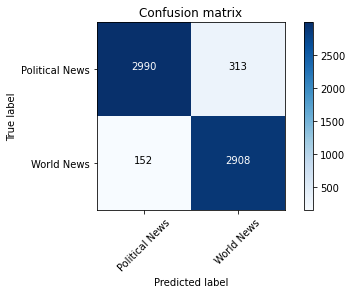

In [87]:
score = accuracy_score(y_true=ytest, y_pred=y_pred)

print("Accuracy: %0.3f" % score)

cm = confusion_matrix(y_true=ytest, y_pred=y_pred)

plot_confusion_matrix(cm=cm, classes=["Political News", "World News"])

In [88]:
sorted(zip(model.coef_[0], cv.get_feature_names_out()))[:100]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: Attribute `coef_` was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


[(-14.155060909468236, 'antonin'),
 (-14.155060909468236, 'antonin scalia'),
 (-14.155060909468236, 'arkansas'),
 (-14.155060909468236, 'barack obama signature'),
 (-14.155060909468236, 'bernie'),
 (-14.155060909468236, 'bernie sander'),
 (-14.155060909468236, 'biden'),
 (-14.155060909468236, 'carson'),
 (-14.155060909468236, 'cfpb'),
 (-14.155060909468236, 'chris christie'),
 (-14.155060909468236, 'christie'),
 (-14.155060909468236, 'cleveland'),
 (-14.155060909468236, 'clinton email'),
 (-14.155060909468236, 'congressional republican'),
 (-14.155060909468236, 'conway'),
 (-14.155060909468236, 'court nominee'),
 (-14.155060909468236, 'created reuters'),
 (-14.155060909468236, 'created reuters editorial'),
 (-14.155060909468236, 'created reuters editorial staff'),
 (-14.155060909468236, 'democratic national'),
 (-14.155060909468236, 'democratic national committee'),
 (-14.155060909468236, 'democratic nominee'),
 (-14.155060909468236, 'democratic rival'),
 (-14.155060909468236, 'democra

## **Testing the model**

In [90]:
text = ["as unitedstates budget fight looms republicans flip their fiscal scriptwashington reuters the head of a conservative republican faction in the unitedstates congress who voted this month for a huge expansion of the national debt to pay for tax cuts called himself a fiscal conservative on sunday and urged budget restraint in in keeping with a sharp pivot under way among republicans unitedstates representative mark meadows speaking on cbs face the nation drew a hard line on federal spending which lawmakers are bracing to do battle over in january when they return from the holidays on wednesday lawmakers will begin trying to pass a federal budget in a fight likely to be linked to other issues such as immigration policy even as the november congressional election campaigns approach in which republicans will seek to keep control of congress president donald trump and his republicans want a big budget increase in military spending while democrats also want proportional increases for non defense discretionary spending on programs that support education scientific research infrastructure public health and environmental protection the trump administration has already been willing to say we re going to increase non defense discretionary spending by about percent meadows chairman of the small but influential house freedom caucus said on the program now democrats are saying that s not enough we need to give the government a pay raise of to percent for a fiscal conservative i don t see where the rationale is eventually you run out of other people s money he said meadows was among republicans"]

In [91]:
test_cv = cv.transform(raw_documents=text)

In [92]:
test_cv.shape

(1, 5000)

In [93]:
result = model.predict(X=test_cv)

In [94]:
print("Political News") if result[0] == 0 else print("World News")

Political News


# **Apply PassiveAggressiveClassifier Algorithm**

In [96]:
pac = PassiveAggressiveClassifier()

In [97]:
pac.fit(X=xtrain, y=ytrain)

PassiveAggressiveClassifier()

Accuracy: 0.917
Confusion matrix, without normalization


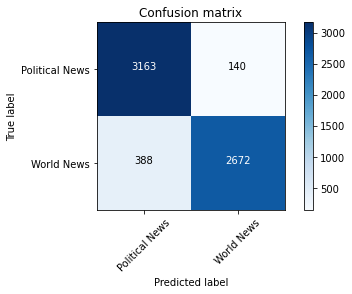

In [98]:
y_pred2 = pac.predict(X=xtest)

score2 = accuracy_score(y_true=ytest, y_pred=y_pred2)

print("Accuracy: %0.3f" % score2)

cm2 = confusion_matrix(y_true=ytest, y_pred=y_pred2)

plot_confusion_matrix(cm=cm2, classes=["Political News", "World News"])


In [99]:
from sklearn.ensemble import RandomForestClassifier

# **Apply RandomForestClassifier**

In [100]:
# Here, n_estimators=200 means 200 decision tree will be created.
# Here, criterion="gini" means the decision tree follow this rule to make decission tree

rfc = RandomForestClassifier(n_estimators=200, criterion="gini")

In [101]:
rfc.fit(X=xtrain, y=ytrain)

y_pred3 = rfc.predict(X=xtest)

Accuracy: 0.931
Confusion matrix, without normalization


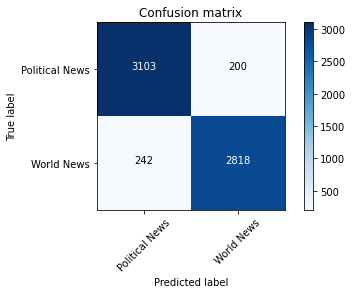

In [102]:
score3 = accuracy_score(y_true=ytest, y_pred=y_pred3)

print("Accuracy: %0.3f" % score3)

cm3 = confusion_matrix(y_true=ytest, y_pred=y_pred3)

plot_confusion_matrix(cm=cm3, classes=["Political News", "World News"])

# **Apply Multinomial Classifier with Hyperparameter**

In [103]:
# Demo test

np.arange(0,1,0.1) # np.arange(start, stop, step)

# Demo end

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [104]:
previous_score = 0

for alpha in np.arange(0, 1, 0.1): # np.arange(start, stop, step)
    sub_classifier = MultinomialNB(alpha=alpha)

    sub_classifier.fit(X=xtrain, y=ytrain)

    y_predict = sub_classifier.predict(X=xtest)

    model_score = accuracy_score(y_true=ytest, y_pred=y_predict)

    if model_score > previous_score:
        classifier = sub_classifier
    print("Alpha: {}, Score: {}%".format(alpha, model_score))

/usr/local/lib/python3.7/dist-packages/sklearn/naive_bayes.py:557: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  % _ALPHA_MIN


Alpha: 0.0, Score: 0.9284928492849285%
Alpha: 0.1, Score: 0.9280213735659281%
Alpha: 0.2, Score: 0.9278642149929278%
Alpha: 0.30000000000000004, Score: 0.9277070564199277%
Alpha: 0.4, Score: 0.9275498978469275%
Alpha: 0.5, Score: 0.9273927392739274%
Alpha: 0.6000000000000001, Score: 0.9272355807009273%
Alpha: 0.7000000000000001, Score: 0.9272355807009273%
Alpha: 0.8, Score: 0.9270784221279271%
Alpha: 0.9, Score: 0.9270784221279271%
